Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


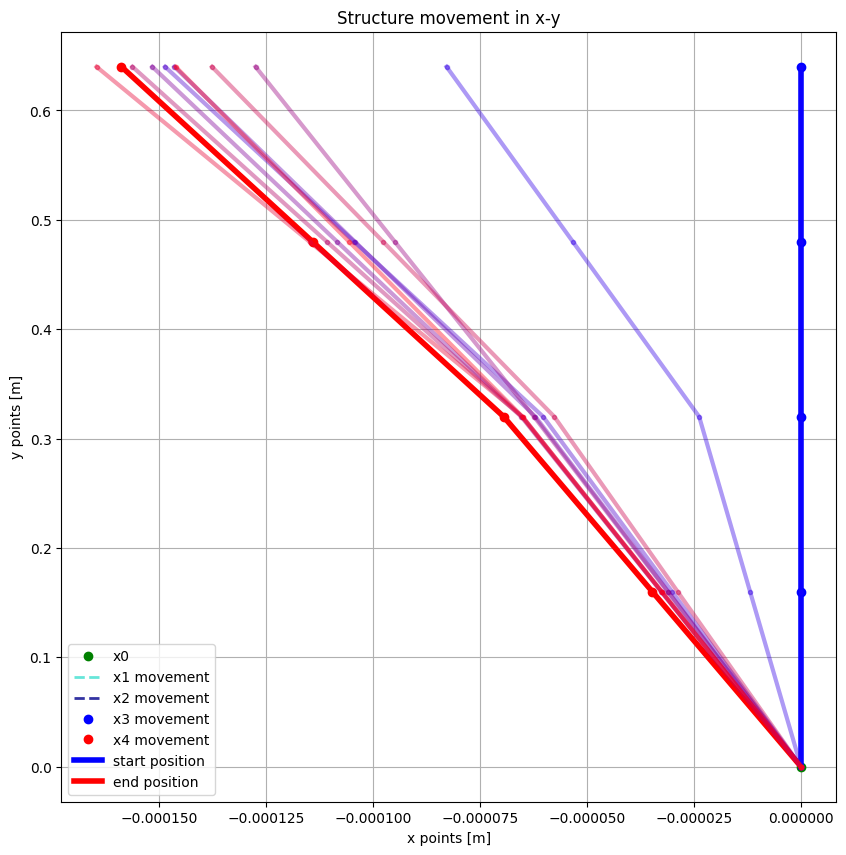

In [1]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive


drive.mount('/content/drive')
root_path = 'drive/My Drive/TU/Master/MEP/Paper/Working_file_copied_from_final_code/Experiment_3+2b'
!pip install mat4py
!pip install geneticalgorithm
import sys, os

#path_dir = os.getcwd()
#sys.path.append(path_dir+"/Functions")

sys.path.append(root_path+"/Functions")

from general_functions import *

from integrator_functions import *
from muscle_functions import *
from matrices_functions import * #can make specific later if bloated
from constants_functions import *
from plot_functions import *
from save_functions import *

#The stiffness region that the muscles start in must be in the experiment name. Names are:
#mostpos,verypos,newpos,newneg,mostneg for stiffness region 1-5. Region name must be preceded by stiff_start_
experiment_name = 'new2b23_minimal_cocontraction_stiff_start_newneg_'
save = False #If true, the experiment data will be saved to a dataset in /Results/data

#protocol indicates the system configuration. 'straight_up_delay' for experiment 2 perturbation test, 'reaching' for experiment 3 robustness test
protocol = 'straight_up_delay'#'stroeve','straight_up','straight_up_delay'

#model type determines whether Huxley or Hill functions are used, v_type determines the used vce equation in the Huxley model (old is used) and FL_.. determines the used FL model (hill is used)
model_type,v_type,FL_type='huxley','v_old','FL_hill' #'huxley','hill'---'v_old','v_new'---'FL_0','FL_hill','FL_huxley'
hill_type = 'stroeve'#determines the hill model used. 'thijs' for hill_expanded, 'stroeve' for hill_simple
f_type = 'f_damped_fullgrav'#determines how the force vector in matrices_functions.py is calculated. 'f_damped_fullgrav','f_damped__pgrav','f_damped__0grav','f_undamped_fullgrav','f_undamped__pgrav','f_undamped__0grav' ------------apply manually to matrices_functions.py
straight_og=True #If True, the current_muscle_starting_lengths will be defined with the arm in the straight up position
Fmax_muscles = False #keep False, this is set manually in the constants_functions function

#some experiment parameters
m3_value = 1            #allows for manual scaling of ball mass and inertia
f_factor = 1.0          #alllows for manual scaling of muscle force
t0 = 0.0                #time start point (s)
tf = 3.0                #time end point   (s)
t_stimulation = 0.1     #s at this time, the muscle stimulation will start
t_pertubation = 0.25    #s at this time, the system perturbation will be applied. If False, no perturbation
h_step = 0.001          #stepsize         (s)
muscle_number = 6       #nr of muscles used
tot_bridge_nr = 15000   #number of cross-bridges in the Huxley Model
step_nr = int((tf-t0)/h_step)

stim_multiplier_list = [0.9]#cycle through a list of excitation levels, 1 is max. eg. 1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01

for multiplier_nr in range(len(stim_multiplier_list)):
    stim_multiplier = stim_multiplier_list[multiplier_nr]
    mus_vals = muscle_vals_func()

    for muscle_model_nr in range(1):
        if muscle_model_nr==0:
            model_type='huxley'
        if muscle_model_nr==1:
            model_type='hill'
            hill_type = 'thijs'
        if muscle_model_nr==1:
            model_type='hill'
            hill_type = 'stroeve'





        if model_type == 'huxley':
            specific_save_name = str(model_type)+'_stim_mult'+str(stim_multiplier)
        if model_type == 'hill':
            specific_save_name = str(model_type)+'_'+str(hill_type)+'_stim_mult'+str(stim_multiplier)
        if protocol == 'straight_up':
            starting_a1 = 0.5*sm.pi
        if protocol == 'straight_up_delay':
            starting_a1 = 0.5*sm.pi
        if protocol == 'stroeve':
            starting_a1 = 0.2*sm.pi



        l1, l2,l3,l4,m1, m2, J1, J2,F_mtc1,F_mtc2,F_mtc3,F_mtc4,F_mtc5,F_mtc6,r1,r2,B1,B2,thetar1,thetar2,PE_sh1,PE_sh2,PE_xm1,PE_xm2,T_max1,T_max2 = sm.symbols('l_1,l_2,l_3,l_4, m_1, m_2, J_1, J_2, F_{mtc_1},F_{mtc_2},F_{mtc_3},F_{mtc_4},F_{mtc_5},F_{mtc_6},r_1,r_2,B_1,B_2,theta_{r1},theta_{r2},PE_{sh1},PE_{sh2},PE_{xm1},PE_{xm2},T_{max1},T_{max2}')
        t = sm.symbols('t')
        alpha1 = sm.Function('alpha1')(t)
        alpha2 = sm.Function('alpha2')(t)
        alpha3 = sm.Function('alpha3')(t)
        J3, m3 = sm.symbols('J_3,m_3')

        #The joint locations and body center of masses are defined
        x0=0
        y0=0
        x1=0.5*l1*(sm.cos(alpha1))
        y1=0.5*l1*(sm.sin(alpha1))
        x2=2*x1
        y2=2*y1
        x3=x2+0.5*l2*(sm.cos(alpha2))#alpha1 +
        y3=y2+0.5*l2*(sm.sin(alpha2))#alpha1 +
        x4=x2+l2*(sm.cos(alpha2))#alpha1 +
        y4=y2+l2*(sm.sin(alpha2))#alpha1 +

        #Here the starting and ending locations of the muscles are defined, which are later included in the state vector
        #this makes the starts and endings of the muscles scale directly with the joint angle
        #start is defined as the lowest point in the original stroeve image
        xm1_start=-sm.sin(starting_a1)*r1 #-sm.sin(alpha1)*r1
        ym1_start=sm.cos(starting_a1)*r1  #sm.cos(alpha1)*r1
        xm1_end  =x2*l3/l1
        ym1_end  =y2*l3/l1
        xm2_start=sm.sin(starting_a1)*r1#sm.sin(alpha1)*r1
        ym2_start=-sm.cos(starting_a1)*r1#-sm.cos(alpha1)*r1
        xm2_end  =x2*l3/l1
        ym2_end  =y2*l3/l1
        xm3_start=x2*(l1-l4)/l1
        ym3_start=y2*(l1-l4)/l1
        xm3_end  =x2-sm.sin(alpha2)*r1#alpha1 +
        ym3_end  =y2+sm.cos(alpha2)*r1#alpha1 +
        xm4_start=x2*(l1-l4)/l1
        ym4_start=y2*(l1-l4)/l1
        xm4_end  =x2+sm.sin(alpha2)*r1#alpha1 +
        ym4_end  =y2-sm.cos(alpha2)*r1#alpha1 +
        xm5_start=-sm.sin(starting_a1)*r1
        ym5_start=sm.cos(starting_a1)*r1
        xm5_end  =xm3_end
        ym5_end  =ym3_end
        xm6_start=sm.sin(starting_a1)*r1
        ym6_start=-sm.cos(starting_a1)*r1
        xm6_end  =xm4_end
        ym6_end  =ym4_end

        #I might need to redefine these to simply increase or decrease the length in a pulley-like fashion
        l_mtc1=sm.sqrt((xm1_end-xm1_start)**2+(ym1_end-ym1_start)**2)
        l_mtc2=sm.sqrt((xm2_end-xm2_start)**2+(ym2_end-ym2_start)**2)
        l_mtc3=sm.sqrt((xm3_end-xm3_start)**2+(ym3_end-ym3_start)**2)
        l_mtc4=sm.sqrt((xm4_end-xm4_start)**2+(ym4_end-ym4_start)**2)
        l_mtc5=sm.sqrt((xm5_end-xm5_start)**2+(ym5_end-ym5_start)**2)
        l_mtc6=sm.sqrt((xm6_end-xm6_start)**2+(ym6_end-ym6_start)**2)

        x = sm.Matrix([alpha1, x1, y1,alpha2,x3,y3,alpha3,x4,y4])
        q = sm.Matrix([alpha1,alpha2,alpha3])
        T_mat = x.diff(t).jacobian(q.diff(t))

        #define constants and specifieds
        p_protocol_stroeve = {
            l1: 0.32,    # m
            l2: 0.32,  # m
            l3: 0.125,  # m
            l4: 0.125,    #m
            m1: 1.8,    # kg
            J1: 0.015,    # kg*m^2 https://aip-scitation-org.tudelft.idm.oclc.org/doi/pdf/10.1063/1.3479844#:~:text=We%20can%20see%20that%20the,0.1kgm2%20to%200.5kgm2.
            m2: 1.6,    # m
            J2: 0.013,    # kg*m^2
            r1: 0.03,   #rad
            r2: 0.03,   #rad
            m3: 0.00000001,
            J3: 0.0000001, #ball: 2/5*M*r2. Say r of 0.05m, m of 2: 0.002
            B1: 0.3,#Shoulder damping, Nms/rad
            B2: 0.2,#Elbow damping, Nms/rad
            thetar1: 0.2*np.pi,#Shoulder rest angle, rad np.pi/3 OG
            thetar2: 0.2*np.pi,#Elbow rest angle, rad np.pi/2 OG
            PE_sh1: 18,#Shoulder PE shape
            PE_sh2: 18,#Elbow PE shape
            PE_xm1: 0.5*np.pi,#Shoulder PE range, rad
            PE_xm2: 0.5*np.pi,#Elbow PE range, rad
            T_max1: 75,#maximum shoulder torque, winters and stark 85
            T_max2: 51,#maximum elbow torque, winters and stark 85
        }

        p_protocol_straight_up = {
            l1: 0.32,    # m
            l2: 0.32,  # m
            l3: 0.125,  # m
            l4: 0.125,    #m
            m1: 1.8,    # kg
            J1: 0.015,    # kg*m^2 https://aip-scitation-org.tudelft.idm.oclc.org/doi/pdf/10.1063/1.3479844#:~:text=We%20can%20see%20that%20the,0.1kgm2%20to%200.5kgm2.
            m2: 1.6,    # m
            J2: 0.013,    # kg*m^2
            r1: 0.03,   #rad
            r2: 0.03,   #rad
            m3: m3_value,#0.00000001,#
            J3: 0.0008*m3_value, #ball: 2/5*M*r^2. Say r of 0.04m, m of 1: 0.00064. Circle: 0.5*m*r^2v #0.00000001,
            B1: 0.3,#Shoulder damping, Nms/rad
            B2: 0.2,#Elbow damping, Nms/rad
            thetar1: 0.5*np.pi,#Shoulder rest angle, rad
            thetar2: 0.5*np.pi,#Elbow rest angle, rad
            PE_sh1: 18,#Shoulder PE shape
            PE_sh2: 18,#Elbow PE shape
            PE_xm1: 0.5*np.pi,#Shoulder PE range, rad
            PE_xm2: 0.5*np.pi,#Elbow PE range, rad
            T_max1: 75,#maximum shoulder torque, winters and stark 85
            T_max2: 51,#maximum elbow torque, winters and stark 85
        }
        #initial conditions
        init_protocol_stroeve = {
            alpha1: 0.2*np.pi,
            alpha2: 0.2*np.pi,
            alpha3: 0.0*np.pi,
            alpha1.diff(t): 0,
            alpha2.diff(t): 0,
            alpha3.diff(t): 0,
        }
        init_protocol_straight_up = {
            alpha1: 0.500000*np.pi,
            alpha2: 0.50000*np.pi,
            alpha3: 0.0*np.pi,
            alpha1.diff(t): 0,
            alpha2.diff(t): 0.001*np.pi,
            alpha3.diff(t): 0,
        }
        init_protocol_straight_up_delay = {
            alpha1: 0.50*np.pi,
            alpha2: 0.50*np.pi,
            alpha3: 0.0*np.pi,
            alpha1.diff(t): 0.0*np.pi,
            alpha2.diff(t): 0.0*np.pi,
            alpha3.diff(t): 0.0*np.pi,
        }
        pert_protocol_straight_up_delay = {
            alpha1: 0.0*np.pi,
            alpha2: 0.0*np.pi,
            alpha3: 0.0*np.pi,
            alpha1.diff(t): 0.0*np.pi,
            alpha2.diff(t): 0.005*np.pi,
            alpha3.diff(t): 0.0*np.pi,
        }

        if protocol == 'straight_up':
            init = init_protocol_straight_up
            p = p_protocol_straight_up
            t_pertubation = False
            pert_vals = False
        if protocol == 'stroeve':
            init = init_protocol_stroeve
            p = p_protocol_stroeve
            pert_vals = False
        if protocol == 'straight_up_delay':
            init = init_protocol_straight_up_delay
            p = p_protocol_straight_up
            pert_vals = np.array(list(pert_protocol_straight_up_delay.values()))

        r = {
            F_mtc1:   0.000000001,  # N
            F_mtc2:   0.000000001,  # N
            F_mtc3:   0.000000001,  # N
            F_mtc4:   0.000000001,  # N
            F_mtc5:   0.000000001,  # N
            F_mtc6:   0.000000001,  # N
        }

        #invoke system calculation functions
        F_newton, M_newton, q_args, qd_args, p_args, r_args = F_M_vars_calc(l1, l2,l3,l4,m1, m2, J1, J2,F_mtc1,F_mtc2,F_mtc3,F_mtc4,F_mtc5,F_mtc6,r1,r2,t,alpha1,alpha2,x0,x1,x2,x3,x4,y0,y1,y2,y3,y4,p,r,J3,m3,alpha3,B1,B2,thetar1,thetar2,PE_sh1,PE_sh2,PE_xm1,PE_xm2,T_max1,T_max2,f_type);
        M_tmt, Q_tmt, C_M, C_Q, A, b, eval_A, eval_b, eval_C, eval_Cd, eval_Cq, g_conv = matrices_func(M_newton, F_newton, q_args, qd_args, p_args, r_args, T_mat,x,q,t);
        init_vals = np.array(list(init.values()))

        #Make arrays of the values in order for use in the numerical functions
        q_vals = np.array([init_vals[0],init_vals[1],init_vals[2]])
        qd_vals = np.array([init_vals[3], init_vals[4], init_vals[5]])
        p_vals = np.array([p[p_sym] for p_sym in p_args])
        r_vals = np.array([r[r_sym] for r_sym in r_args])
        eval_xs = sm.lambdify((q_args, p_args), [x0,x0,x1,x2,x3,x4])
        eval_ys = sm.lambdify((q_args, p_args), [y0,y0,y1,y2,y3,y4])
        eval_ls = sm.lambdify((q_args, p_args), [l_mtc1, l_mtc2,l_mtc3,l_mtc4,l_mtc5,l_mtc6])

        #make an input stimulation vector
        step_nr = int((tf-t0)/h_step)
        input_STIM = [[]]*muscle_number
        starting_step = int((t_stimulation/tf)*step_nr)
        input_STIM[0] = np.ones(step_nr+2)*stim_multiplier*1
        input_STIM[1] = np.ones(step_nr+2)*stim_multiplier*1
        input_STIM[2] = np.ones(step_nr+2)*stim_multiplier*1
        input_STIM[3] = np.ones(step_nr+2)*stim_multiplier*1
        input_STIM[4] = np.ones(step_nr+2)*stim_multiplier*1
        input_STIM[5] = np.ones(step_nr+2)*stim_multiplier*1
        input_STIM[0][0:starting_step] = 0 #this way, step input should be applied at 0.01 s
        input_STIM[1][0:starting_step] = 0
        input_STIM[2][0:starting_step] = 0
        input_STIM[3][0:starting_step] = 0
        input_STIM[4][0:starting_step] = 0
        input_STIM[5][0:starting_step] = 0

        #create function to iterate over with rk4
        eval_rhs2 = lambda t, s, r_vals: eval_rhs(t, s, p_vals, r_vals,eval_A, eval_b)[0]  # don't output the Lagrange multipliers
        if (model_type != 'hill') or (hill_type != 'thijs'):
            for kkk in range(muscle_number):#scale the maximum force variables
                mus_vals[kkk][7]*=f_factor

        #execute calculations
        t_vals, s_vals, coords_vals,mtc_vels,calculated_muscle_forces,states,activation,mus_vals_changed,K_SE_list,K_CE_list,force_vector = rk4_integrator(eval_rhs2, t0, tf, init_vals, t_pertubation,pert_vals,h_step, r_vals, muscle_number, tot_bridge_nr, eval_xs, eval_ys, eval_ls,p_vals,mus_vals,Fmax_muscles,f_factor,False,True,input_STIM,True,False,model_type,hill_type,v_type,FL_type,straight_og,specific_save_name,experiment_name)#t_vals, s_vals, coords_vals,mtc_vels,calculated_muscle_forces,states,STIM,mus_vals_changed,K_SE_list,K_CE_list,force_vector = rk4_integrator(eval_rhs2, t0, tf, init_vals, h_step, r_vals, muscle_number, tot_bridge_nr, eval_xs, eval_ys, eval_ls,p_vals,mus_vals,False,True,input_STIM,True,False,model_type,v_type,FL_type,hill_type,True,True)

        #some data preparation
        l_mtcs = [[]]*muscle_number
        for muscle in range(muscle_number):
            l_mtcs[muscle] = coords_vals[:,2][:,muscle]
        if model_type =='huxley':
            lCEs = np.zeros((muscle_number,len(states[0][:,-2])))
            lSEs = np.zeros((muscle_number,len(states[0][:,-2])))
            for i in range(muscle_number):
                lCEs[i] = states[i][:,-2]
            for i in range(muscle_number):
                lSEs[i] = coords_vals[:,2,i] - lCEs[i]
        if model_type =='hill':
            if hill_type == 'stroeve':
                lCEs = np.zeros((muscle_number,len(states[0])))
                vCEs = np.zeros((muscle_number,len(states[0])))
                for muscle in range(muscle_number):
                    lCEs[muscle] = l_mtcs[muscle] - 0.02
                    vCEs[muscle] = np.gradient(lCEs[muscle],h_step)
            if hill_type == 'thijs':
                lCEs = np.zeros((muscle_number,len(states[0])))
                vCEs = np.zeros((muscle_number,len(states[0])))
                for muscle in range(muscle_number):
                    lCEs[muscle] = states[muscle][:,0]
                    vCEs[muscle] = force_vector[muscle][:,7]

        #plot data and saves it to \Results
        if model_type =='huxley':
            plot_huxley_full(t_vals, s_vals, coords_vals,mtc_vels,calculated_muscle_forces,states,input_STIM,t0,tf,t_pertubation,h_step,muscle_number,tot_bridge_nr,step_nr,mus_vals_changed,np.array(list(p.values())),v_type,FL_type,f_type,K_SE_list,K_CE_list,lCEs,lSEs,save,experiment_name,specific_save_name)
        if model_type == 'hill':
            plot_hill_full(t_vals, s_vals, coords_vals,mtc_vels,calculated_muscle_forces,states,input_STIM,t0,tf,t_pertubation,h_step,muscle_number,tot_bridge_nr,step_nr,mus_vals,save,experiment_name,specific_save_name)
        #save data
        if save == True:
            if model_type =='huxley':
                save_huxley(l_mtcs,tot_bridge_nr,states,force_vector,mtc_vels,input_STIM,lCEs,lSEs,K_CE_list,K_SE_list,coords_vals,s_vals,t_vals,experiment_name, specific_save_name)
            if model_type =='hill':
                save_hill(l_mtcs,calculated_muscle_forces,force_vector,mtc_vels,input_STIM,lCEs,vCEs,t_vals,s_vals,experiment_name,specific_save_name)


        # if model_type =='huxley':
        #     plot_huxley_single_muscle(t_vals, s_vals, coords_vals,mtc_vels,calculated_muscle_forces,states,input_STIM,t0,tf,t_pertubation,h_step,muscle_number,tot_bridge_nr,step_nr,mus_vals_changed,np.array(list(p.values())),v_type,FL_type,f_type,K_SE_list,K_CE_list,lCEs,lSEs,save,experiment_name,specific_save_name)

        plot_movement_static(t_vals, s_vals, coords_vals,mtc_vels,calculated_muscle_forces,states,input_STIM,t0,tf,h_step,muscle_number,tot_bridge_nr,step_nr,mus_vals,save,experiment_name,specific_save_name)

#More experiment result figures and tables are saved to the Results folder in each run

In [ ]:
Fa#animate
'''
def plot_points(s):
    xs = eval_xs(s[:3], p_vals)
    ys = eval_ys(s[:3], p_vals)
    return xs, ys
#animation test
fig, ax = plt.subplots(figsize=(6, 6),
                       subplot_kw={'autoscale_on': True,
                                   'xlim':(-0.005, 0.005),
                                   'ylim':(-0.3, 0.7)})
#ax.set_aspect('equal')
ax.grid()

#ax.axhline(p[yD], linestyle="--", color="C1")
line, = ax.plot([], [], 'o-', lw=2)
#ax.plot(p[xE], p[yE], 'o', markersize=8, color="C1")
time_template = 'time = %.1fs'
time_text = ax.text(0.8, 0.1, '', transform=ax.transAxes)
fps = 60
num_frames = tf*fps
divisor = int(len(t_vals)/num_frames)

def animate(i):
    x_plot, y_plot = plot_points(s_vals[1::divisor][i])
    line.set_data(x_plot, y_plot)
    time_text.set_text(time_template % (t_vals[1::divisor][i]))
    return line, time_text

ani = animation.FuncAnimation(fig, animate, len(t_vals[1::divisor]), blit=True)

display(HTML(ani.to_jshtml(fps=fps)))'''

'\ndef plot_points(s):\n    xs = eval_xs(s[:3], p_vals)\n    ys = eval_ys(s[:3], p_vals)\n    return xs, ys\n#animation test\nfig, ax = plt.subplots(figsize=(6, 6),\n                       subplot_kw={\'autoscale_on\': True,\n                                   \'xlim\':(-0.005, 0.005),\n                                   \'ylim\':(-0.3, 0.7)})\n#ax.set_aspect(\'equal\')\nax.grid()\n\n#ax.axhline(p[yD], linestyle="--", color="C1")\nline, = ax.plot([], [], \'o-\', lw=2)\n#ax.plot(p[xE], p[yE], \'o\', markersize=8, color="C1")\ntime_template = \'time = %.1fs\'\ntime_text = ax.text(0.8, 0.1, \'\', transform=ax.transAxes)\nfps = 60\nnum_frames = tf*fps\ndivisor = int(len(t_vals)/num_frames)\n\ndef animate(i):\n    x_plot, y_plot = plot_points(s_vals[1::divisor][i])\n    line.set_data(x_plot, y_plot)\n    time_text.set_text(time_template % (t_vals[1::divisor][i]))\n    return line, time_text\n\nani = animation.FuncAnimation(fig, animate, len(t_vals[1::divisor]), blit=True)\n\ndisplay(HTML(an